In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [3]:
# Load the dataset
df = pd.read_csv('Static_dataset.csv')

# Display the first few rows
df.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1


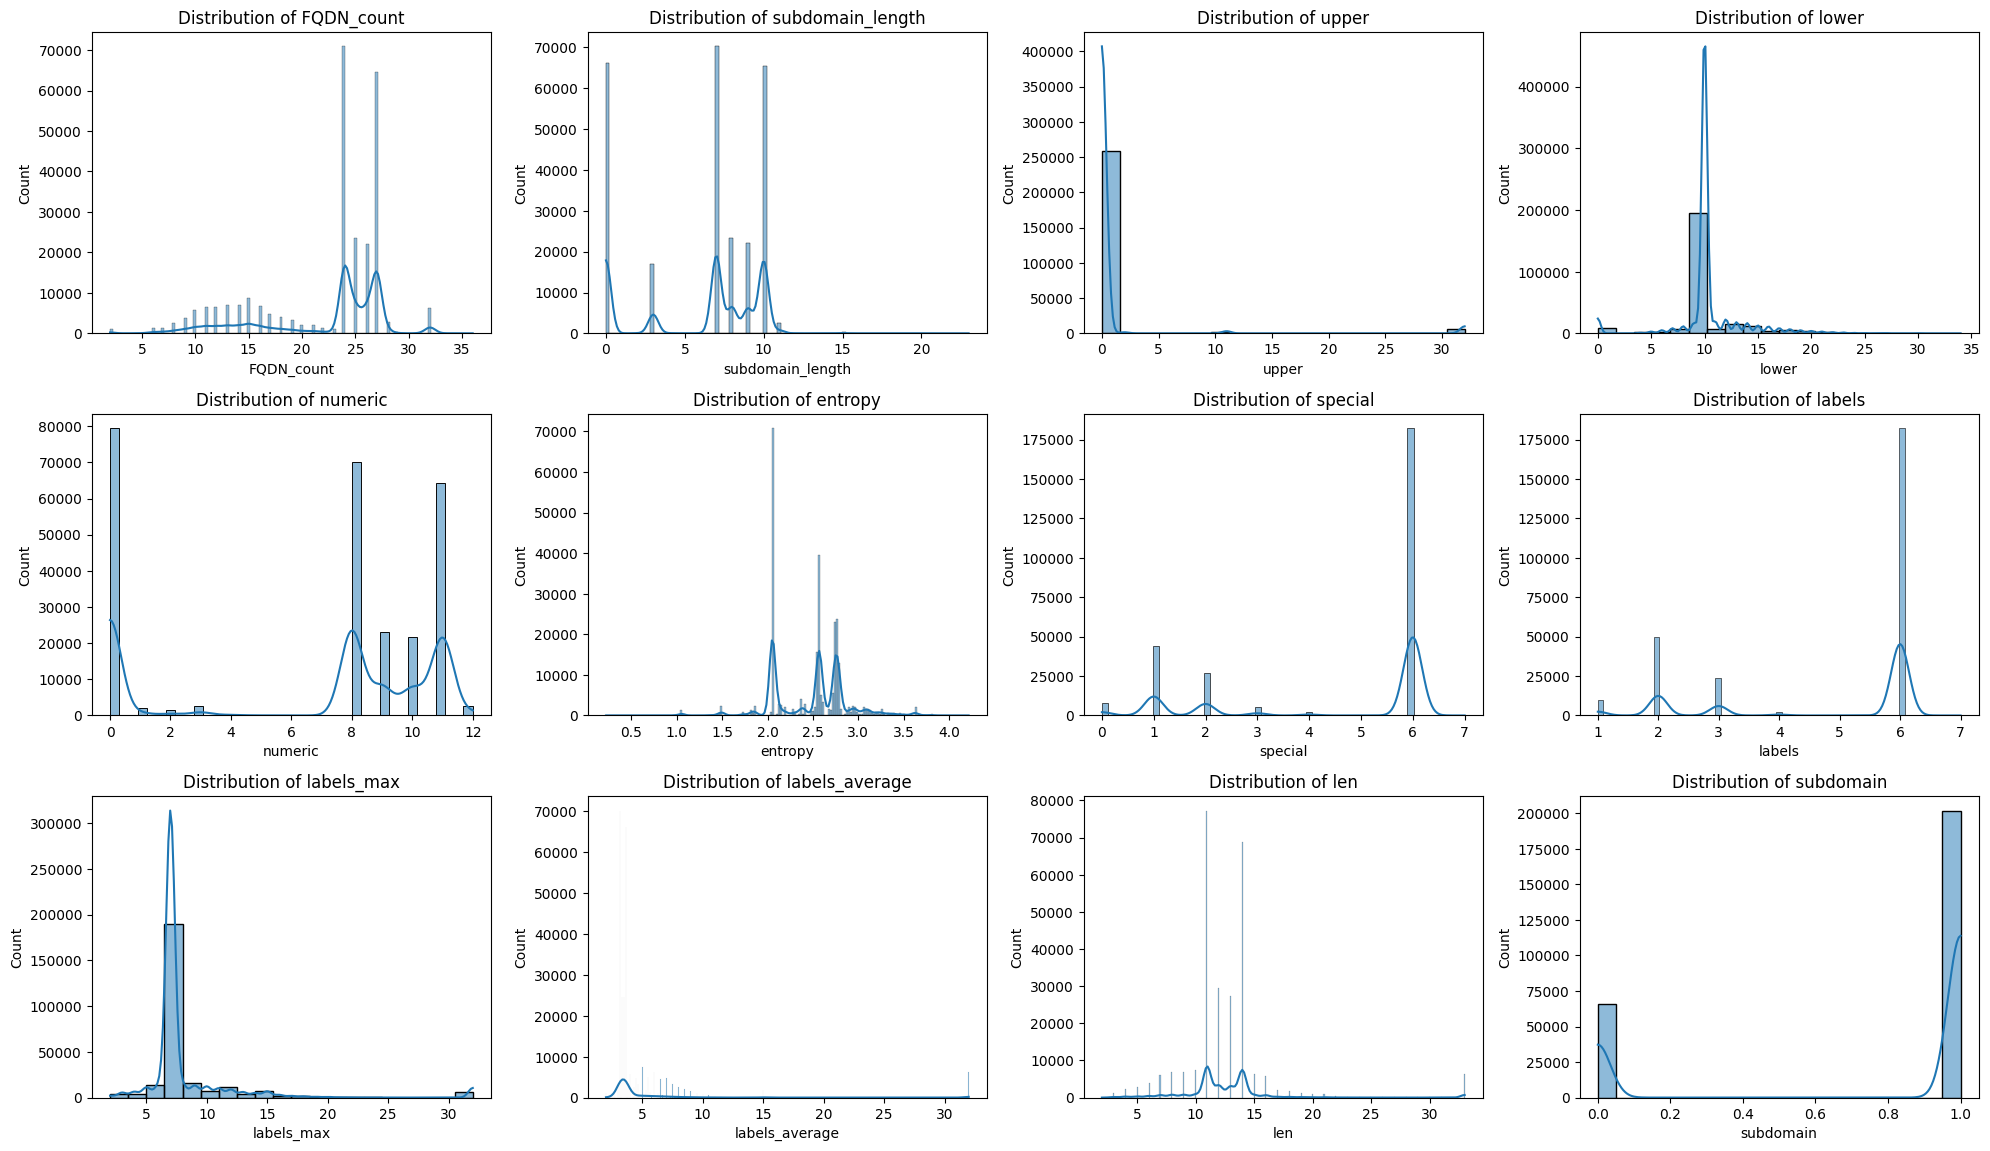

In [4]:
# Set up the figure size
plt.figure(figsize=(20, 15))

# Plot the distribution of each feature
features = df.columns.drop(['timestamp', 'Target Attack', 'longest_word', 'sld'])
for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

plt.show()

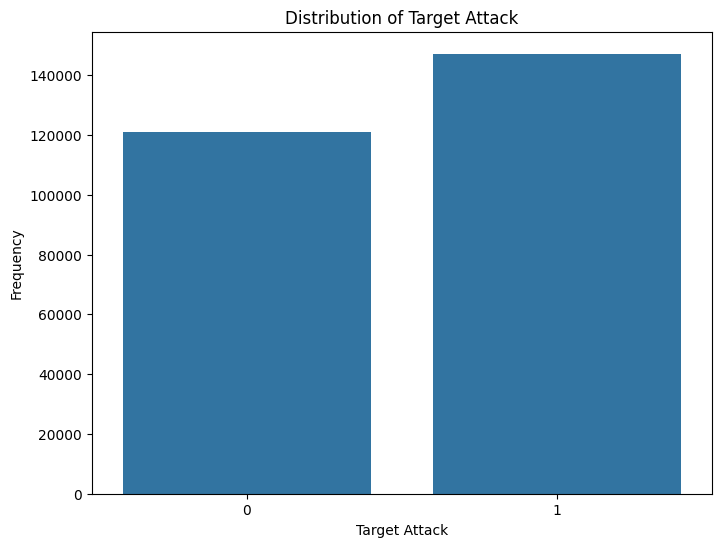

In [5]:
# Plotting the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Target Attack', data=df)
plt.title('Distribution of Target Attack')
plt.xlabel('Target Attack')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Calculate the percentage of each class in the target variable
class_distribution = df['Target Attack'].value_counts(normalize=True) * 100

class_distribution

Target Attack
1    54.902378
0    45.097622
Name: proportion, dtype: float64

In [7]:
# Calculate skewness for each feature
skewness = df[features].skew()

skewness

FQDN_count         -1.101731
subdomain_length   -0.590480
upper               5.988737
lower               0.343449
numeric            -0.594384
entropy            -0.140156
special            -0.902972
labels             -0.903680
labels_max          3.979910
labels_average      5.087081
len                 2.634801
subdomain          -1.176397
dtype: float64

In [8]:
# Identify columns with data type as 'object' (typically strings or mixed types)
string_columns = df.select_dtypes(include=['object']).columns

# Display the unique values for each string column to understand their nature
string_values = {col: df[col].unique() for col in string_columns}

string_values

{'timestamp': array(['56:19.8', '07:23.9', '23:15.1', ..., '31:45.8', '51:38.3',
        '00:40.7'], dtype=object),
 'longest_word': array(['2', 'local', 'pforzheim', ..., 'match', 'pantheon', 'sizer'],
       dtype=object),
 'sld': array(['192', 'local', 'pforzheim-bisons', ..., 'telia', 'boomstream',
        'e2ma'], dtype=object)}

In [9]:
# Check for missing values in the entire dataset
missing_values = df.isnull().sum()

missing_values

timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        8
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

In [10]:
# Drop the timestamp column
df = df.drop(columns=['timestamp'])

# Handle missing values in the 'longest_word' column
df['longest_word'].fillna('missing', inplace=True)

# Check the cardinality of 'longest_word' and 'sld' columns
cardinality = {
    "longest_word": df['longest_word'].nunique(),
    "sld": df['sld'].nunique()
}

cardinality

{'longest_word': 6225, 'sld': 11112}

In [11]:
# Frequency encoding for 'longest_word' and 'sld'
df['longest_word_freq'] = df['longest_word'].map(df['longest_word'].value_counts())
df['sld_freq'] = df['sld'].map(df['sld'].value_counts())

# Drop the original 'longest_word' and 'sld' columns
df_transformed = df.drop(columns=['longest_word', 'sld'])

df_transformed.head()


,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack,longest_word_freq,sld_freq
0,27,10,0,10,11,2.570417,6,6,7,3.666667,14,1,1,109981,109517
1,27,10,0,10,11,2.767195,6,6,7,3.666667,14,1,1,109981,109517
2,26,9,0,10,10,2.742338,6,6,7,3.500000,13,1,0,109981,109517
3,27,10,0,10,11,2.570417,6,6,7,3.666667,14,1,1,109981,109517
4,15,9,0,11,0,2.929439,4,3,5,4.333333,15,1,1,1707,1703


In [12]:
# Separate features and target variable
X = df_transformed.drop(columns=['Target Attack'])  # We exclude 'timestamp' as it was deemed not directly useful earlier
y = df_transformed['Target Attack']

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_importance_rf

sld_freq             0.261626
longest_word_freq    0.213263
FQDN_count           0.157806
subdomain_length     0.107255
labels               0.089282
numeric              0.044346
lower                0.029674
special              0.029332
labels_average       0.028534
subdomain            0.021692
upper                0.011014
len                  0.002887
labels_max           0.001858
entropy              0.001432
dtype: float64

In [13]:
# Apply ANOVA F-test
f_scores, p_values = f_classif(X, y)

# Store the results in a DataFrame
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
}).sort_values(by='F-Score', ascending=False)

anova_results

,Feature,F-Score,P-Value
4,numeric,150204.138241,0.000000e+00
6,special,137390.213441,0.000000e+00
12,longest_word_freq,130664.653672,0.000000e+00
1,subdomain_length,130396.819432,0.000000e+00
13,sld_freq,129735.419530,0.000000e+00
7,labels,128620.678405,0.000000e+00
0,FQDN_count,124767.197802,0.000000e+00
11,subdomain,90540.732541,0.000000e+00
3,lower,25666.539455,0.000000e+00
10,len,6992.186945,0.000000e+00


In [52]:
# Applying correlation
correlation_matrix = df_transformed.corr()

# Focusing on the correlation with the target variable
target_correlation = correlation_matrix['Target Attack'].sort_values(ascending=False)

# Removing the target variable from the correlation series
target_correlation = target_correlation.drop(labels='Target Attack')

# Filtering features with significant correlation (absolute value)
significant_correlation = target_correlation[np.abs(target_correlation) > 0.2]

significant_correlation


numeric              0.599252
special              0.582107
longest_word_freq    0.572448
subdomain_length     0.572053
sld_freq             0.571075
labels               0.569414
FQDN_count           0.563563
subdomain            0.502469
lower               -0.295599
Name: Target Attack, dtype: float64

In [53]:
# Select top features from Random Forest and ANOVA F-test
top_rf_features = feature_importance_rf.head(10).index.tolist()
top_anova_features = anova_results['Feature'].head(10).tolist()
top_correlation_features = significant_correlation.head(10).index.tolist()

# Take the union of both feature sets
selected_features = list(set(top_rf_features + top_anova_features + top_correlation_features))

selected_features

['longest_word_freq',
 'special',
 'subdomain_length',
 'numeric',
 'labels_average',
 'FQDN_count',
 'subdomain',
 'lower',
 'labels',
 'sld_freq',
 'len']

In [15]:
# Extract the selected features and target variable
X_selected = df_transformed[selected_features]
y_selected = df_transformed['Target Attack']

# Perform a random split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# Check the proportions of classes in the train and test sets
train_class_distribution = y_train.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)

train_class_distribution, test_class_distribution

(Target Attack
 1    0.548481
 0    0.451519
 Name: proportion, dtype: float64,
 Target Attack
 1    0.55029
 0    0.44971
 Name: proportion, dtype: float64)

In [16]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5], X_test_scaled[:5]  # Display the first 5 rows of scaled data for train and test sets

(array([[ 0.98739697,  0.67060977,  1.01026769,  1.00014274, -0.24887352,
          0.78484972,  0.57188794, -0.12639478,  0.67193675,  0.98860763,
          0.3381669 ],
        [ 0.13967342,  0.67060977,  0.2410336 ,  0.33359443, -0.35777414,
          0.28482199,  0.57188794, -0.12639478,  0.67193675,  0.14850446,
         -0.37833374],
        [ 0.98739697,  0.67060977,  1.01026769,  1.00014274, -0.24887352,
          0.78484972,  0.57188794, -0.12639478,  0.67193675,  0.98860763,
          0.3381669 ],
        [-1.35443587, -1.61470022, -1.55384595, -1.44386773, -0.50297497,
         -2.7153444 , -1.74859433, -1.68321183, -1.54600796, -1.35043321,
         -2.05016855],
        [ 0.98739697,  0.67060977,  1.01026769,  1.00014274, -0.24887352,
          0.78484972,  0.57188794, -0.12639478,  0.67193675,  0.98860763,
          0.3381669 ]]),
 array([[ 0.13967342,  0.67060977,  0.2410336 ,  0.33359443, -0.35777414,
          0.28482199,  0.57188794, -0.12639478,  0.67193675,  0.14850

In [37]:
# Define hyperparameter grid for Logistic Regression
lgr_params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'C': [0.1, 1, 10],
    'max_iter': [100, 200, 300]
}

In [18]:
# Define hyperparameter grid for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6, 8, 10, 12],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 500, 1000]
}

In [19]:
# Define a function to evaluate the model's performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    }
    return metrics

In [38]:
# Initialize Logistic Regression classifier
lgr_classifier = LogisticRegression(random_state=42, verbose=0)

# Randomized search for Logistic Regression
lgr_random_search = RandomizedSearchCV(lgr_classifier, param_distributions=lgr_params, n_iter=10, scoring='f1',
                                       n_jobs=-1, cv=3, random_state=42, verbose=1)

# Fit the Logistic Regression model
lgr_random_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters for Logistic Regression
lgr_best_params = lgr_random_search.best_params_

lgr_best_params

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Jacky\AppData

{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 100, 'C': 0.1}

In [34]:
# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")

# Randomized search for XGBoost
xgb_random_search = RandomizedSearchCV(xgb_classifier, param_distributions=xgb_params, n_iter=10, scoring='f1',
                                       n_jobs=-1, cv=3, random_state=42, verbose=1)

# Fit the xgboost model
xgb_random_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters for XGBoost
xgb_best_params = xgb_random_search.best_params_

xgb_best_params

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


{'subsample': 0.8,
 'n_estimators': 1000,
 'min_child_weight': 10,
 'max_depth': 8,
 'learning_rate': 0.3,
 'gamma': 1,
 'colsample_bytree': 1.0}

In [39]:
# Evaluate logistic regression model
lgr_metrics = evaluate_model(lgr_random_search, X_train_scaled, y_train, X_test_scaled, y_test)

# Evaluate xgboost model
xgb_metrics = evaluate_model(xgb_random_search, X_train_scaled, y_train, X_test_scaled, y_test)

lgr_metrics, xgb_metrics

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Jacky\AppData

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


({'Accuracy': 0.8239433992763264,
  'Precision': 0.7614447784012925,
  'Recall': 0.9903289949385394,
  'F1 Score': 0.860934047046113,
  'ROC AUC': 0.8060637401334665},
 {'Accuracy': 0.8276985439488703,
  'Precision': 0.7616768528880089,
  'Recall': 0.9996836587129428,
  'F1 Score': 0.8645997205421092,
  'ROC AUC': 0.806322171818503})

In [63]:
# Predict on the test data using the Logistic Regresion classifier
y_pred_lgr = lgr_random_search.predict(X_test_scaled)
y_prob_lgr = lgr_random_search.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

y_pred_lgr[:10], y_prob_lgr[:10]  # Display the first 10 predictions and associated probabilities

(array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int64),
 array([7.45906870e-01, 9.46838461e-06, 7.45906870e-01, 7.45906870e-01,
        7.69890138e-01, 7.69890138e-01, 7.45906870e-01, 7.59239756e-01,
        4.63279414e-03, 7.75204921e-01]))

In [40]:
# Predict on the test data using the XGBoosting classifier
y_pred_xgb = xgb_random_search.predict(X_test_scaled)
y_prob_xgb = xgb_random_search.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

y_pred_xgb[:10], y_prob_xgb[:10]  # Display the first 10 predictions and associated probabilities

(array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1]),
 array([7.5843185e-01, 6.2044164e-05, 7.5843185e-01, 7.5843185e-01,
        7.5856453e-01, 7.5856453e-01, 7.5843185e-01, 7.6073194e-01,
        2.0620413e-05, 7.5894797e-01], dtype=float32))

Plot Metrics for both models

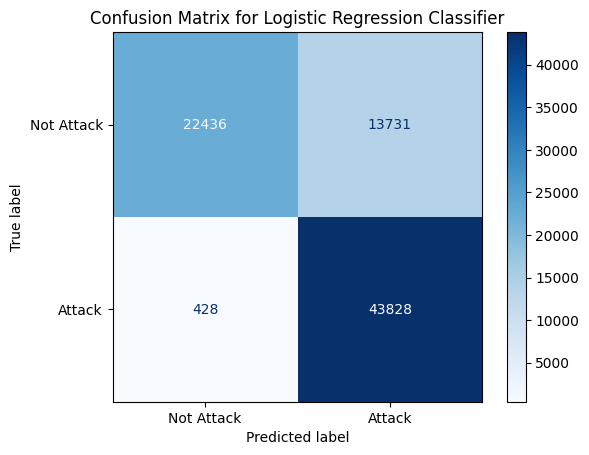

In [60]:
# Compute the confusion matrix
cm0 = confusion_matrix(y_test, y_pred_lgr)

# Display the confusion matrix using ConfusionMatrixDisplay
cmd0 = ConfusionMatrixDisplay(confusion_matrix=cm0, display_labels=['Not Attack', 'Attack'])
cmd0.plot(cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression Classifier')
plt.show()

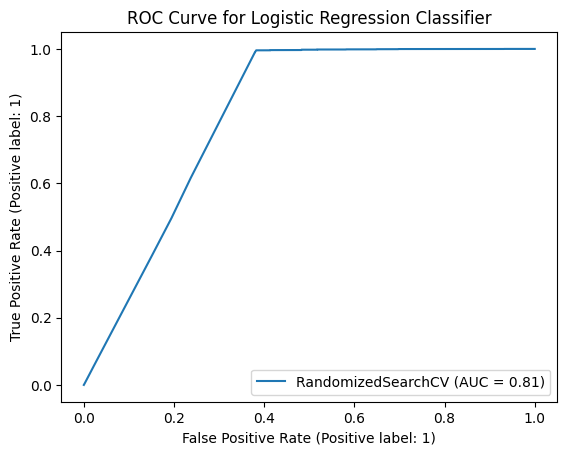

In [61]:
# Use the RocCurveDisplay function to plot the ROC Curve
roc_display0 = RocCurveDisplay.from_estimator(lgr_random_search, X_test_scaled, y_test)
plt.title('ROC Curve for Logistic Regression Classifier')
plt.show()

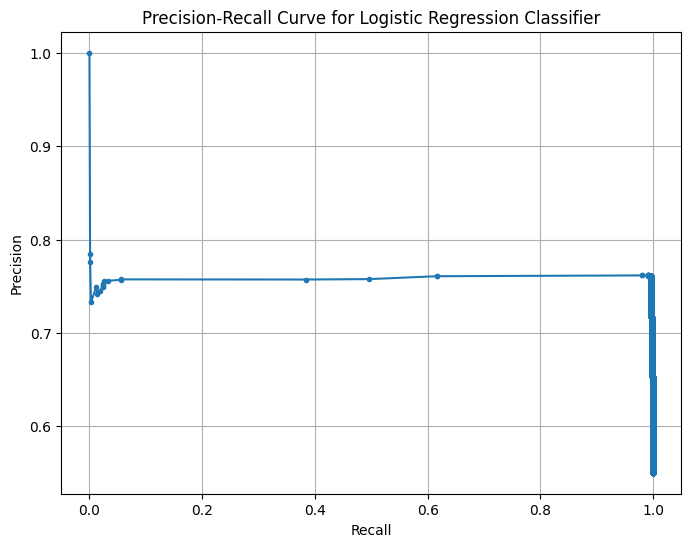

In [62]:
# Compute precision and recall values
precision0, recall0, _0 = precision_recall_curve(y_test, lgr_random_search.predict_proba(X_test_scaled)[:, 1])

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall0, precision0, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Classifier')
plt.grid(True)
plt.show()

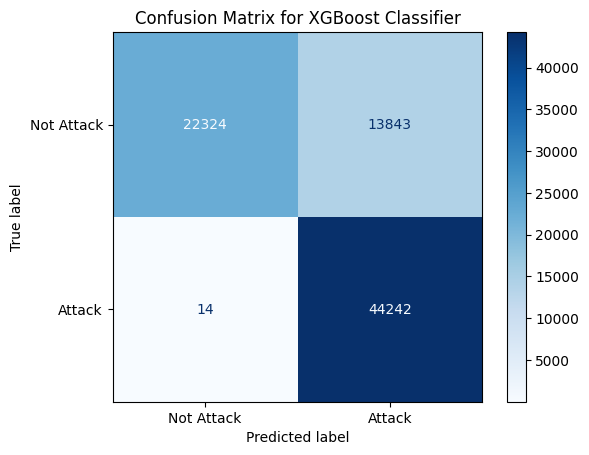

In [66]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Display the confusion matrix using ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Attack', 'Attack'])
cmd.plot(cmap='Blues')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()

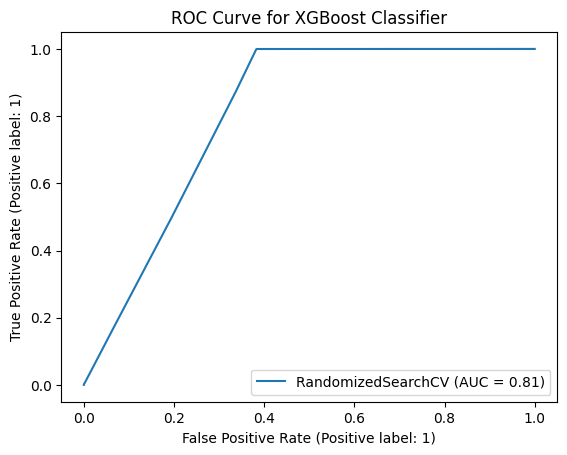

In [65]:
# Use the RocCurveDisplay function to plot the ROC Curve
roc_display = RocCurveDisplay.from_estimator(xgb_random_search, X_test_scaled, y_test)
plt.title('ROC Curve for XGBoost Classifier')
plt.show()


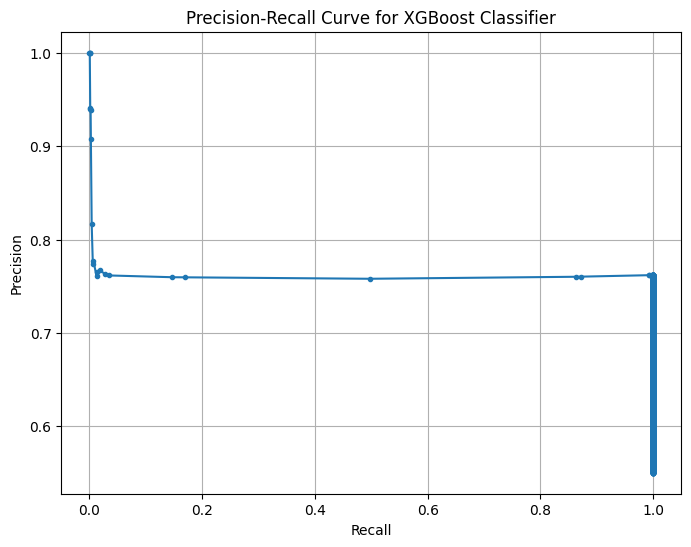

In [64]:
# Compute precision and recall values
precision, recall, _ = precision_recall_curve(y_test, xgb_random_search.predict_proba(X_test_scaled)[:, 1])

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost Classifier')
plt.grid(True)
plt.show()

In [28]:
# Save the XGBoosting model as dynamic model to a file
dynamic_model_filename = "dynamic_xgboosting_model-v3.pkl"
joblib.dump(xgb_random_search, dynamic_model_filename)

dynamic_model_filename

'dynamic_xgboosting_model-v3.pkl'

In [29]:
# Save the XGBoosting model as static model to a file
static_model_filename = "static_xgboosting_model-v3.pkl"
joblib.dump(xgb_random_search, static_model_filename)

static_model_filename

'static_xgboosting_model-v3.pkl'